$ H = \frac{p^2}{2} + \frac{x^2}{2} + V(s) \frac{x^4}{4} $

- integrable : $V(s) = \tau \theta(s) \theta(L-s)$

- non-integrable : $V(s) = \tau L \delta(s)$

In [1]:
import numpy as np
from math import ceil
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from pImpactR.util import naff

In [2]:
tau =  1.0

Ltot = 2*np.pi*(1.0+1.0/4.0-0.03)
L1   = 2*np.pi*(1.0/4.0-0.03)

NTURN = [128,256,512,1024]

nx = 100
dx = 1.0
npt = nx*nx

pipe_rad = 100

In [3]:
def drift0(x,p,ds):
    x[:] = x + ds*p
    
def kick0(x,p,ds):
    p[:] = p - ds*x
      
def kickInt(x,p,ds):
    p[:] = p - ds*x - tau*x*x*x*ds
    
def kickDelta(x,p,L):
    p[:] = p - tau*x*x*x*L    

In [4]:
def Map0(x,p,l,nstep,pipe_rad):
    ds = l/nstep
    drift0(x,p,0.5*ds)
    for i in range(nstep-1):
        kick0(x,p,ds)
        drift0(x,p,ds)
        if i%10==0:
            iLost = x**2+p**2 > pipe_rad*pipe_rad
            x[iLost] = 0.0
            p[iLost] = 0.0
    kick0(x,p,ds)
    drift0(x,p,0.5*ds)
    
    
def Map1(x,p,l,nstep,pipe_rad):
    ds = l/nstep
    drift0(x,p,0.5*ds)
    for i in range(nstep-1):
        kickInt(x,p,ds)
        drift0(x,p,ds)
        if i%10==0:
            iLost = x**2+p**2 > pipe_rad*pipe_rad
            x[iLost] = 0.0
            p[iLost] = 0.0
    kickInt(x,p,ds)
    drift0(x,p,0.5*ds)

In [5]:
def OneTurnMap_integrable(x,p,Ltot,L1,ds_estimate,pipe_rad):
    Larc = Ltot-L1
    Narc = ceil(0.5*Larc/ds_estimate)
    N1   = ceil(L1/ds_estimate)
    Map0(x,p,0.5*Larc,Narc,pipe_rad)
    Map1(x,p,L1,N1,pipe_rad)
    Map0(x,p,0.5*Larc,Narc,pipe_rad)
    
    
def OneTurnMap_nonintegrable(x,p,Ltot,L1,ds_estimate,pipe_rad):
    Narc = ceil(0.5*Ltot/ds_estimate)
    Map0(x,p,0.5*Ltot,Narc,pipe_rad)
    kickDelta(x,p,L1)
    Map0(x,p,0.5*Ltot,Narc,pipe_rad)

In [6]:
def getTBT(nturn,Ltot,L1,ds_estimate,pipe_rad,flagIntegrable=True):
    x = np.zeros(nx*nx)
    p = np.zeros(nx*nx)
    TBTF1 = np.zeros([nturn,2,nx*nx])
    TBTF2 = np.zeros([nturn,2,nx*nx])
    i = 0
    for xtmp in np.linspace(-1,1,nx):
        for ptmp in np.linspace(-1,1,nx):
            x[i] = xtmp
            p[i] = ptmp
            i = i + 1
    
    for i in range(nturn):
        TBTF1[i,0,:] = copy(x[:])
        TBTF1[i,1,:] = copy(p[:])
        if flagIntegrable:
            OneTurnMap_integrable(x,p,Ltot,L1,ds_estimate,pipe_rad)
        else:
            OneTurnMap_nonintegrable(x,p,Ltot,L1,ds_estimate,pipe_rad)
            
    for i in range(nturn):
        TBTF2[i,0,:] = copy(x[:])
        TBTF2[i,1,:] = copy(p[:])
        if flagIntegrable:
            OneTurnMap_integrable(x,p,Ltot,L1,ds_estimate,pipe_rad)
        else:
            OneTurnMap_nonintegrable(x,p,Ltot,L1,ds_estimate,pipe_rad)
            
    
    iLive = TBTF2[-1,0,:] != 0
    TBTF1 = TBTF1[:,:,iLive]
    TBTF2 = TBTF2[:,:,iLive]
    TBTB1 = np.zeros([nturn,2,np.sum(iLive)])
    
    x = copy(TBTF2[0,0,:])
    p = copy(TBTF2[0,1,:])
    for i in range(nturn):
        if flagIntegrable:
            OneTurnMap_integrable(x,p,-Ltot,-L1,-ds_estimate,pipe_rad)
        else:
            OneTurnMap_nonintegrable(x,p,-Ltot,-L1,-ds_estimate,pipe_rad)
        TBTB1[i,0,:] = copy(x[:])
        TBTB1[i,1,:] = copy(p[:])
    
    return TBTF1,TBTF2,TBTB1

In [7]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [8]:
def getTuneDiffusion(TBT1,TBT2):
    npt = len(TBT2[-1,0,:])
    Diff = np.zeros(npt)
    Tune0 = np.zeros(npt)
    for i in range(npt):
        signal = TBT1[:,0,i] - 1j*TBT1[:,1,i]
        signal = signal - np.mean(signal)
        Tune0[i],amp,dummy = naff(1,signal,window_id=1)
        
        signal = TBT2[:,0,i] - 1j*TBT2[:,1,i]
        signal = signal - np.mean(signal)
        tune1,amp,dummy = naff(3,signal,window_id=1)
        
        Diff[i] = np.log10(np.abs(getClosestDiff(Tune0[i],tune1)))
        
    return Diff, Tune0

In [9]:
def getReversalError(TBTF,TBTB):
    Diff = np.log10(np.sqrt( 
                    (TBTF[0,0,:] - TBTB[-1,0,:])**2 + (TBTF[0,1,:] - TBTB[-1,1,:])**2 
                   ) )
    
    return Diff

# Integrable

In [10]:
TBTF1_int = {}
TBTF2_int = {}
TBTB1_int = {}
Tunes_int = {}
dFMA_int = {}
dREM_int = {}

In [11]:
for nturn in NTURN:
    TBTF1_int[nturn],TBTF2_int[nturn],TBTB1_int[nturn] = getTBT(nturn,Ltot,L1,1.0e-3,pipe_rad,flagIntegrable=True)
    dFMA_int[nturn],Tunes_int[nturn] = getTuneDiffusion(TBTF1_int[nturn],TBTF2_int[nturn])
    dREM_int[nturn] = getReversalError(TBTF1_int[nturn],TBTB1_int[nturn])

/home/kilean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


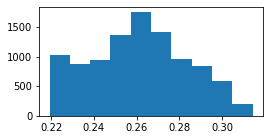

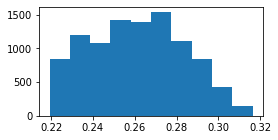

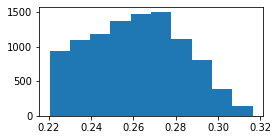

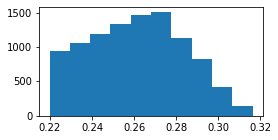

In [12]:
for nturn in NTURN:
    plt.figure(figsize=[4,2])
    plt.hist(Tunes_int[nturn])

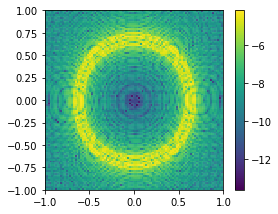

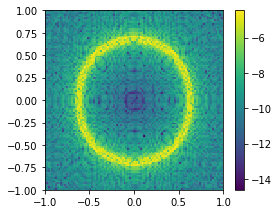

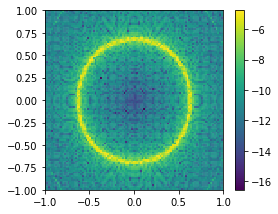

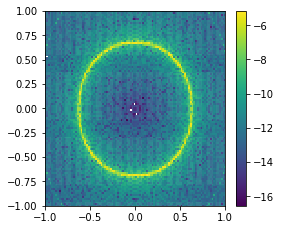

In [13]:
for nturn in NTURN:
    x = TBTF1_int[nturn][0,0,:]
    p = TBTF1_int[nturn][0,1,:]
    c = dFMA_int[nturn]
    fig = plt.figure(figsize=[4,3.3])
    f1=plt.scatter(x,p,c=c,s=1.6,marker='s')
    plt.xlim(-dx,dx)
    plt.ylim(-dx,dx)
    plt.colorbar(f1)
plt.tight_layout()

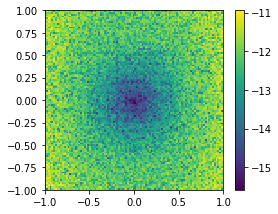

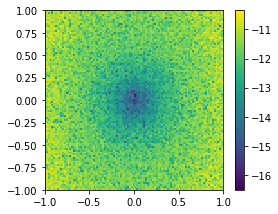

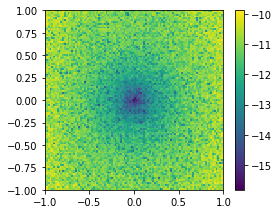

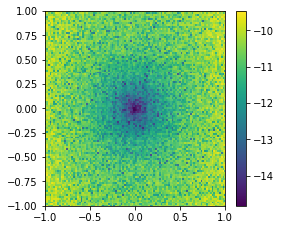

In [14]:
for nturn in NTURN:
    x = TBTF1_int[nturn][0,0,:]
    p = TBTF1_int[nturn][0,1,:]
    c = dREM_int[nturn]
    fig = plt.figure(figsize=[4,3.3])
    f1=plt.scatter(x,p,c=c,s=1.6,marker='s')
    plt.xlim(-dx,dx)
    plt.ylim(-dx,dx)
    plt.colorbar(f1)
plt.tight_layout()

# NonIntegrable pipe_rad=5

In [15]:
NTURN = [128,256,512]

In [16]:
TBTF1_non = {}
TBTF2_non = {}
TBTB1_non = {}
Tunes_non = {}
dFMA_non = {}
dREM_non = {}

pipe_rad = 5

In [17]:
for nturn in NTURN:
    TBTF1_non[nturn],TBTF2_non[nturn],TBTB1_non[nturn] = getTBT(nturn,Ltot,L1,1.0e-2,pipe_rad,flagIntegrable=False)
    dFMA_non[nturn],Tunes_non[nturn] = getTuneDiffusion(TBTF1_non[nturn],TBTF2_non[nturn])
    dREM_non[nturn] = getReversalError(TBTF1_non[nturn],TBTB1_non[nturn])

In [18]:
for nturn in NTURN:
    print(len(TBTF1_non[nturn][0,0,:]))

4738
4279
3780


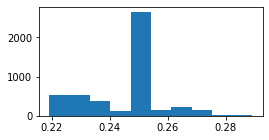

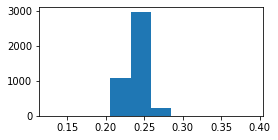

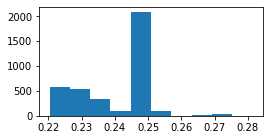

In [19]:
for nturn in NTURN:
    plt.figure(figsize=[4,2])
    plt.hist(Tunes_non[nturn])

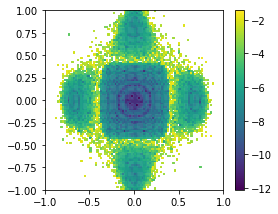

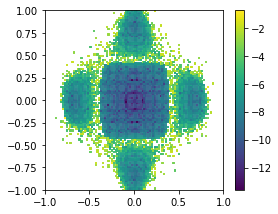

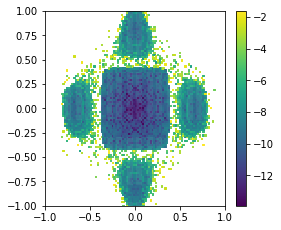

In [20]:
for nturn in NTURN:
    x = TBTF1_non[nturn][0,0,:]
    p = TBTF1_non[nturn][0,1,:]
    c = dFMA_non[nturn]
    fig = plt.figure(figsize=[4,3.3])
    f1=plt.scatter(x,p,c=c,s=1.6,marker='s')
    plt.xlim(-dx,dx)
    plt.ylim(-dx,dx)
    plt.colorbar(f1)
plt.tight_layout()

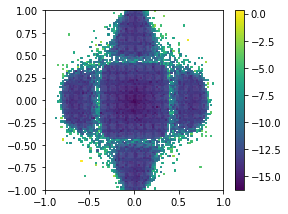

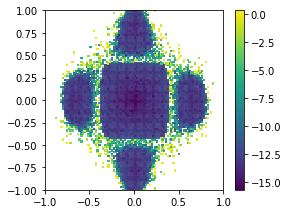

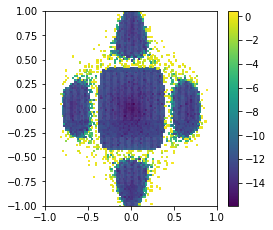

In [21]:
for nturn in NTURN:
    x = TBTF1_non[nturn][0,0,:]
    p = TBTF1_non[nturn][0,1,:]
    c = dREM_non[nturn]
    fig = plt.figure(figsize=[4,3.3])
    f1=plt.scatter(x,p,c=c,s=1.6,marker='s')
    plt.xlim(-dx,dx)
    plt.ylim(-dx,dx)
    plt.colorbar(f1)
plt.tight_layout()

# NonIntegrable pipe_rad=10000

In [22]:
TBTF1_non = {}
TBTF2_non = {}
TBTB1_non = {}
Tunes_non = {}
dFMA_non = {}
dREM_non = {}

pipe_rad = 10000

In [23]:
for nturn in NTURN:
    TBTF1_non[nturn],TBTF2_non[nturn],TBTB1_non[nturn] = getTBT(nturn,Ltot,L1,1.0e-2,pipe_rad,flagIntegrable=False)
    dFMA_non[nturn],Tunes_non[nturn] = getTuneDiffusion(TBTF1_non[nturn],TBTF2_non[nturn])
    dREM_non[nturn] = getReversalError(TBTF1_non[nturn],TBTB1_non[nturn])

In [24]:
for nturn in NTURN:
    print(len(TBTF1_non[nturn][0,0,:]))

4746
4283
3782


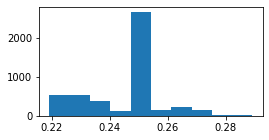

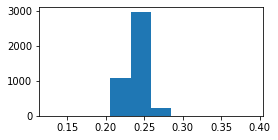

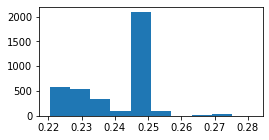

In [25]:
for nturn in NTURN:
    plt.figure(figsize=[4,2])
    plt.hist(Tunes_non[nturn])

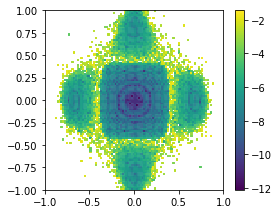

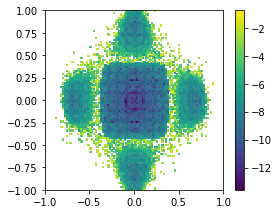

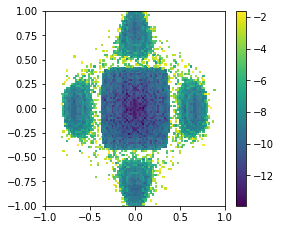

In [26]:
for nturn in NTURN:
    x = TBTF1_non[nturn][0,0,:]
    p = TBTF1_non[nturn][0,1,:]
    c = dFMA_non[nturn]
    fig = plt.figure(figsize=[4,3.3])
    f1=plt.scatter(x,p,c=c,s=1.6,marker='s')
    plt.xlim(-dx,dx)
    plt.ylim(-dx,dx)
    plt.colorbar(f1)
plt.tight_layout()

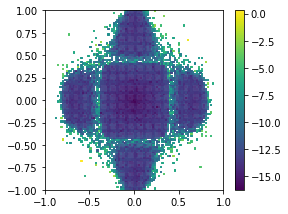

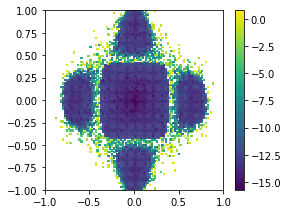

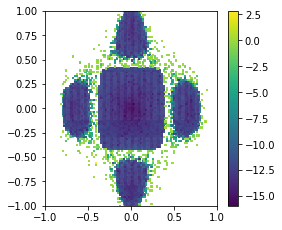

In [27]:
for nturn in NTURN:
    x = TBTF1_non[nturn][0,0,:]
    p = TBTF1_non[nturn][0,1,:]
    c = dREM_non[nturn]
    fig = plt.figure(figsize=[4,3.3])
    f1=plt.scatter(x,p,c=c,s=1.6,marker='s')
    plt.xlim(-dx,dx)
    plt.ylim(-dx,dx)
    plt.colorbar(f1)
plt.tight_layout()

# NonIntegrable pipe_rad=1e9

In [28]:
TBTF1_non = {}
TBTF2_non = {}
TBTB1_non = {}
Tunes_non = {}
dFMA_non = {}
dREM_non = {}

pipe_rad = 1e9

In [29]:
for nturn in NTURN:
    TBTF1_non[nturn],TBTF2_non[nturn],TBTB1_non[nturn] = getTBT(nturn,Ltot,L1,1.0e-2,pipe_rad,flagIntegrable=False)
    dFMA_non[nturn],Tunes_non[nturn] = getTuneDiffusion(TBTF1_non[nturn],TBTF2_non[nturn])
    dREM_non[nturn] = getReversalError(TBTF1_non[nturn],TBTB1_non[nturn])

In [30]:
for nturn in NTURN:
    print(len(TBTF1_non[nturn][0,0,:]))

4750
4283
3782


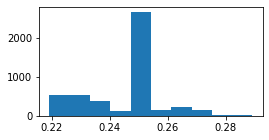

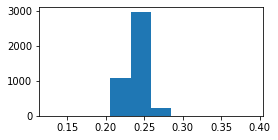

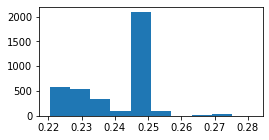

In [31]:
for nturn in NTURN:
    plt.figure(figsize=[4,2])
    plt.hist(Tunes_non[nturn])

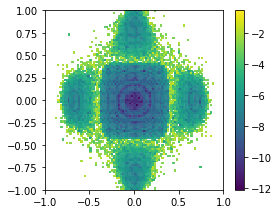

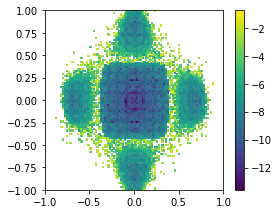

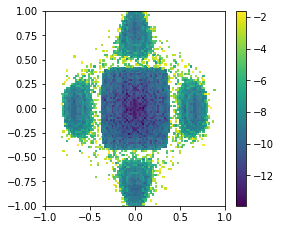

In [32]:
for nturn in NTURN:
    x = TBTF1_non[nturn][0,0,:]
    p = TBTF1_non[nturn][0,1,:]
    c = dFMA_non[nturn]
    fig = plt.figure(figsize=[4,3.3])
    f1=plt.scatter(x,p,c=c,s=1.6,marker='s')
    plt.xlim(-dx,dx)
    plt.ylim(-dx,dx)
    plt.colorbar(f1)
plt.tight_layout()

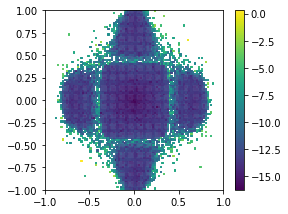

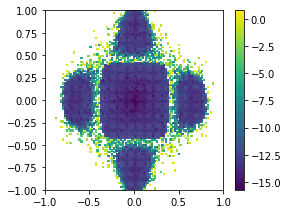

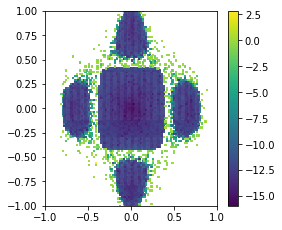

In [33]:
for nturn in NTURN:
    x = TBTF1_non[nturn][0,0,:]
    p = TBTF1_non[nturn][0,1,:]
    c = dREM_non[nturn]
    fig = plt.figure(figsize=[4,3.3])
    f1=plt.scatter(x,p,c=c,s=1.6,marker='s')
    plt.xlim(-dx,dx)
    plt.ylim(-dx,dx)
    plt.colorbar(f1)
plt.tight_layout()